# [E-11] CIFAR-10 DCGAN

## STEP1. 작업환경 구성하기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
print(imageio.__version__)

2.9.0
2.27.0


## STEP 2. 데이터셋 구성하기

In [2]:
import tensorflow as tf
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

(50000, 32, 32, 3)

- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape, test_x.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [6]:
train_x[3444]

array([[[ 0.04313725, -0.35686275, -0.62352941],
        [-0.01176471, -0.40392157, -0.64705882],
        [ 0.09019608, -0.28627451, -0.52941176],
        ...,
        [ 0.05098039, -0.09803922, -0.2627451 ],
        [ 0.20784314,  0.05098039, -0.18431373],
        [ 0.25490196,  0.08235294, -0.16862745]],

       [[-0.00392157, -0.34117647, -0.64705882],
        [ 0.01176471, -0.34901961, -0.6       ],
        [-0.00392157, -0.37254902, -0.58431373],
        ...,
        [-0.10588235, -0.30196078, -0.45098039],
        [-0.04313725, -0.23921569, -0.45882353],
        [ 0.11372549, -0.09019608, -0.3254902 ]],

       [[ 0.14509804, -0.14509804, -0.43529412],
        [ 0.16078431, -0.16862745, -0.39607843],
        [ 0.11372549, -0.25490196, -0.41960784],
        ...,
        [-0.06666667, -0.28627451, -0.44313725],
        [-0.23137255, -0.44313725, -0.65490196],
        [-0.12941176, -0.34901961, -0.57647059]],

       ...,

       [[ 0.05882353, -0.10588235, -0.39607843],
        [ 0

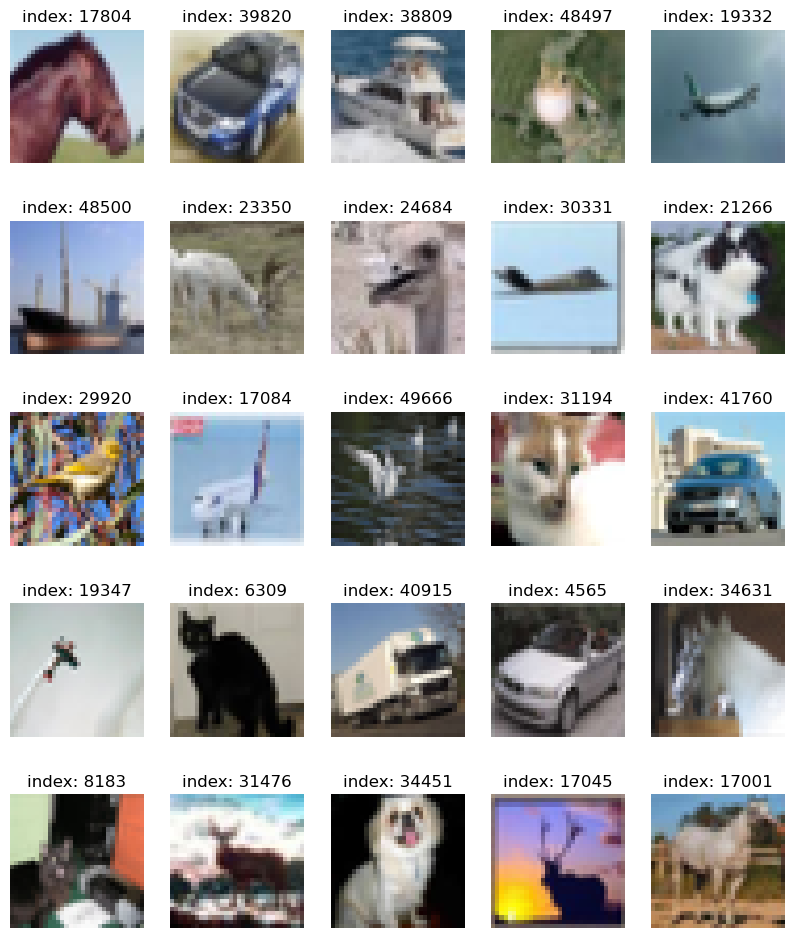

In [45]:

plt.figure(figsize=(10, 12))

for i in range(25):
        r = np.random.randint(1,50000)
        plt.subplot(5, 5, i+1)
        plt.imshow(np.array(train_x[r].reshape(32,32,3)*127.5 + 127.5).astype('uint8')) 
        plt.title(f'index: {r}')
        plt.axis('off')

plt.show()

## STEP 3. 생성자 모델 구현하기

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
def make_generator_model_v1():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [11]:
relu_alpha = 0.01
batch_momentum = 0.8

In [12]:
def make_generator_model_v2():

    # Start
    model = tf.keras.Sequential()
    

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.LeakyReLU(alpha=relu_alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.LeakyReLU(alpha=relu_alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.LeakyReLU(alpha=relu_alpha))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [13]:
def make_generator_model_v3():

    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.LeakyReLU(alpha=relu_alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 128)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.LeakyReLU(alpha=relu_alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.LeakyReLU(alpha=relu_alpha))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='tanh'))

    return model

In [14]:
def make_generator_model_v4():

    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.ReLU())
    
    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 512)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.ReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.ReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='tanh'))

    return model

In [52]:
generator = make_generator_model_v4()

generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8192)              819200    
                                                                 
 batch_normalization_9 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 8, 8, 256)        3277056   
 ranspose)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 256)       

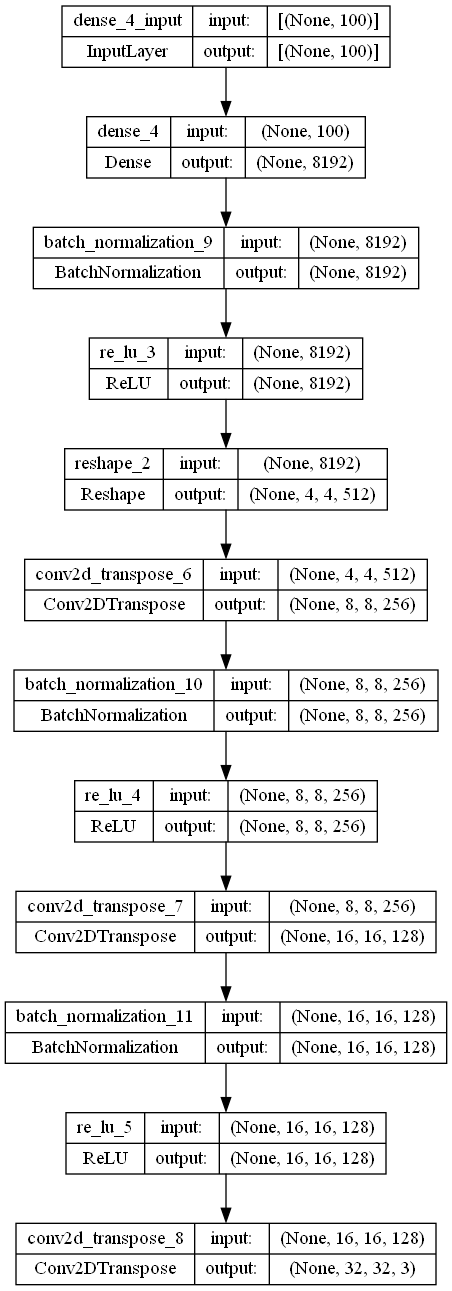

In [53]:
import keras.utils 
keras.utils.plot_model(generator,'attention.png', show_shapes=True)

In [16]:
noise = tf.random.normal([1, 100])


In [17]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [18]:
generated_image[0]

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[-7.6763547e-04, -7.0948823e-05,  1.2241448e-04],
        [-6.8112003e-04,  8.3059870e-04,  4.0338323e-03],
        [-6.0430961e-04,  4.9936944e-03,  1.1606794e-03],
        ...,
        [-1.4236162e-03,  3.3376398e-03,  1.3894761e-03],
        [-4.9162442e-03,  1.2832946e-03, -1.8743670e-03],
        [-4.0138396e-03,  7.1162108e-04, -2.5624072e-03]],

       [[-3.6411374e-04, -8.4523112e-04, -1.3067984e-03],
        [ 5.8789789e-03,  7.4418221e-04, -2.7817336e-04],
        [-4.1767615e-03,  2.0823390e-03, -1.1914596e-04],
        ...,
        [ 2.6149577e-03,  8.4619755e-03, -1.1257029e-02],
        [-3.5742077e-03,  1.6958760e-03, -8.5398677e-04],
        [-4.6446892e-03, -1.9806291e-03, -1.1985728e-03]],

       [[-1.8800396e-04,  4.4193704e-04,  4.3187314e-04],
        [-2.6685537e-03,  1.9598706e-04,  2.0668209e-03],
        [-2.0236210e-03,  3.0933698e-03,  8.4124639e-04],
        ...,
        [-3.5206247e-03, -7.888657

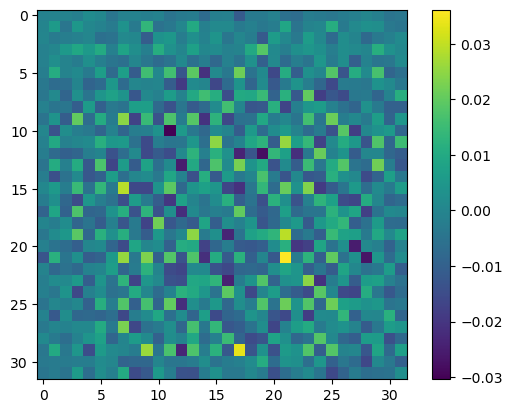

In [19]:
#plt.imshow(generated_image[0].numpy().astype("uint8"))
plt.imshow(generated_image[0, :, :,0])
plt.colorbar()
plt.show()

## STEP 4. 판별자 모델 구현하기

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [20]:
def make_discriminator_model_v1():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [21]:
def make_discriminator_model_v2():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=relu_alpha))
    model.add(layers.Dropout(0.25))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.LeakyReLU(alpha=relu_alpha))
    model.add(layers.Dropout(0.25))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.LeakyReLU(alpha=relu_alpha))
    model.add(layers.Dropout(0.25))
    
    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.LeakyReLU(alpha=relu_alpha))
    model.add(layers.Dropout(0.25))
    
    # Fifth: Flatten Layer
    model.add(layers.Flatten())

    # Sixth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [22]:
def make_discriminator_model_v3():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=relu_alpha))
    model.add(layers.Dropout(0.25))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.LeakyReLU(alpha=relu_alpha))
    model.add(layers.Dropout(0.25))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.LeakyReLU(alpha=relu_alpha))
    model.add(layers.Dropout(0.25))
    
    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.LeakyReLU(alpha=relu_alpha))
    model.add(layers.Dropout(0.25))
    
    # Fifth: Flatten Layer
    model.add(layers.Flatten())
    
    # Sixth: Flatten Layer
    model.add(layers.Dense(512, activation='relu'))

    # Seventh: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [23]:
def make_discriminator_model_v4():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(512, kernel_size=4, strides=2, padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=relu_alpha))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.LeakyReLU(alpha=relu_alpha))
    model.add(layers.Dropout(0.25))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.LeakyReLU(alpha=relu_alpha))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=batch_momentum))
    model.add(layers.LeakyReLU(alpha=relu_alpha))
    model.add(layers.Dropout(0.25))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    model.add(layers.Dense(32, activation='relu'))

    # Fourth: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [24]:
discriminator = make_discriminator_model_v4()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 512)       25088     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 512)       0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 512)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 256)         2097408   
                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                      

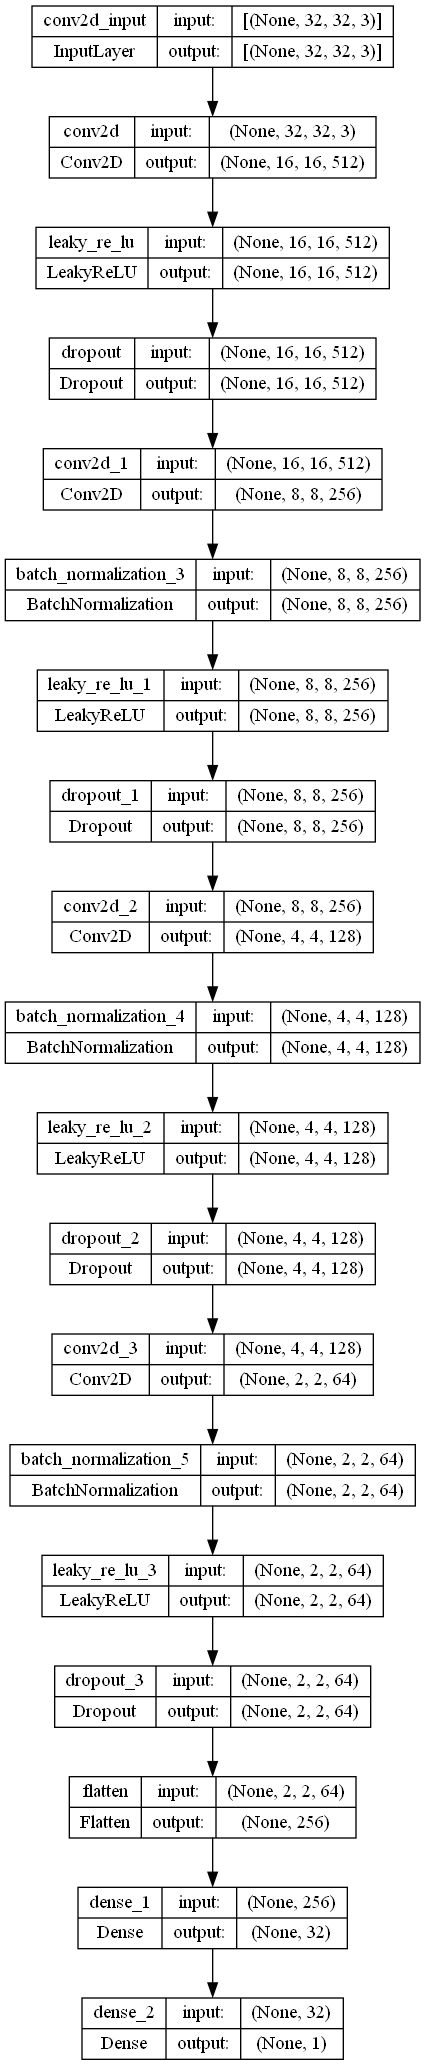

In [54]:
import keras.utils 
keras.utils.plot_model(discriminator,'attention.png', show_shapes=True)

In [25]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49999797]], dtype=float32)>

## STEP 5. 손실함수와 최적화 함수 구현하기

- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [26]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [28]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [29]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## STEP 6. 훈련과정 상세 기능 구현하기

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [31]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [32]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [33]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i]*127.5 + 127.5).astype('uint8')) 
        plt.axis('off')
   
    plt.savefig('./images/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format( epoch, it))

    plt.show()

In [34]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('./images/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [35]:
checkpoint_dir = './images/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행하기

- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

In [36]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [37]:
save_every = 5
EPOCHS = 400

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

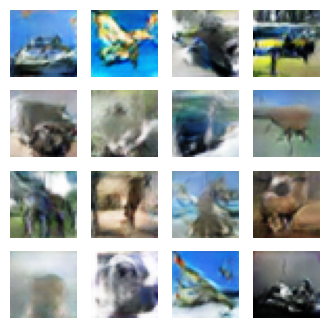

Time for training : 35504 sec


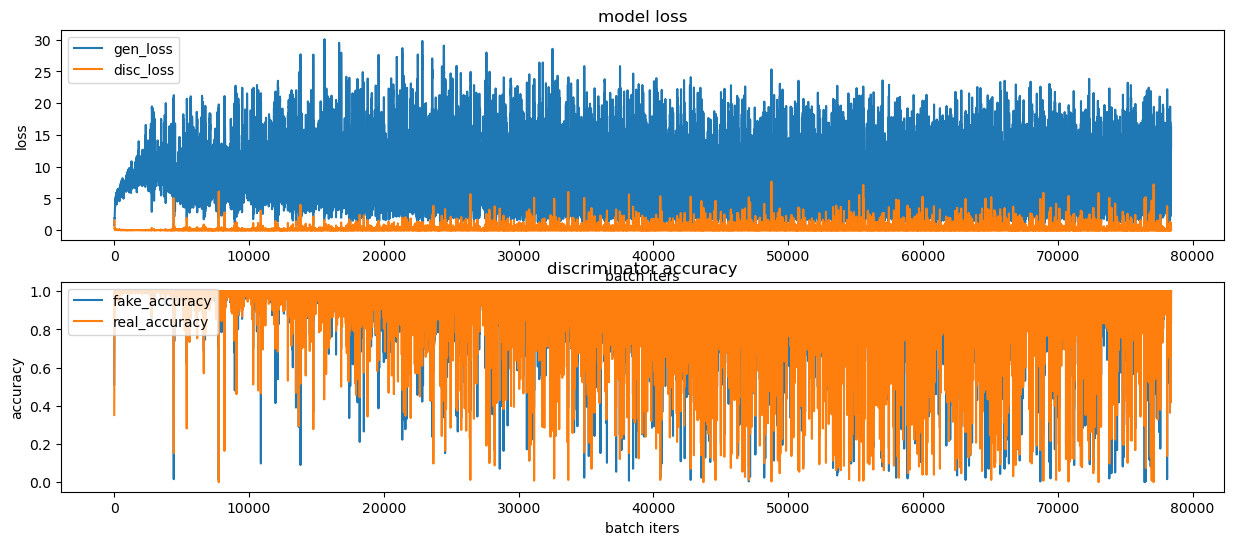

CPU times: total: 9h 52min 27s
Wall time: 9h 51min 48s


In [38]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)


In [39]:
anim_file = './images/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./images/dcgan_newimage/cifar10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

#!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

C:\Users\peunj\AppData\Local\Temp\ipykernel_56344\3634681016.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\peunj\AppData\Local\Temp\ipykernel_56344\3634681016.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## STEP 8. (optional) GAN 훈련 과정 개선하기

- STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

## 8-1 BaseLine 
- make_generator_model_v1
- make_discriminator_model_v1

<img src='https://user-images.githubusercontent.com/95423215/235415189-c05ea83e-41dd-4a93-a890-30fff609aca7.png' width='20%' height='20%'>
<img src='https://user-images.githubusercontent.com/95423215/235415206-b94fdc0c-b0d3-424f-9b7e-22b5d07f977a.gif' width='20%' height='20%'><br>
<img src='https://user-images.githubusercontent.com/95423215/235415200-57b0e6c7-c825-4280-ab4d-d02635082052.png' width='70%' height='50%'>

- 이미지 형태를 알아보기가 어렵다.
- Accuracy에서 Real Accuracy는 0.5로 하강하지만 Fake Accuracy는 0.8~1을 유지하고 있다. 

## 8-2 파라미터 옵션 변경
- make_generator_model_v2
- make_discriminator_model_v2

- relu_alpha = 0.01
- batch_momentum = 0.8

- model.add(layers.BatchNormalization(momentum=batch_momentum))
- model.add(layers.LeakyReLU(alpha=relu_alpha))
- 차원 수 조정

<img src='https://user-images.githubusercontent.com/95423215/235415271-761ce193-c995-409b-a7bb-94a36e721fd0.png' width='20%' height='20%'>
<img src='https://user-images.githubusercontent.com/95423215/235415306-34d32dd1-4528-4e02-8b9e-9f7217aca831.gif' width='20%' height='20%'><br>
<img src='https://user-images.githubusercontent.com/95423215/235415290-627f5969-6e13-4a7f-9785-ebae3f03aa30.png' width='70%' height='50%'>

- 이미지는 여전히 형태를 알아볼 수 없다.
- Accuracy가 다양한 값으로 분포하여 0.5로 수렴하지는 않고 있다. 

## 8-3 discriminator에 Con2d Layer 추가
- make_generator_model_v3
- make_discriminator_model_v3

- 차원수 조정, discriminator에 con2d Layer 추가

<img src='https://user-images.githubusercontent.com/95423215/235415363-eb1a02fd-b75e-4054-81b7-bf0331ace0f4.png' width='20%' height='20%'>
<img src='https://user-images.githubusercontent.com/95423215/235415431-6b9b2cf2-5008-4ee9-9818-13d0e5130db9.gif' width='20%' height='20%'><br>
<img src='https://user-images.githubusercontent.com/95423215/235415375-bebf905b-454c-4cab-8b5c-34bb9e9d4fda.png' width='70%' height='50%'>

- V2에 비해 Fack Accuracy가 하강한 흔적을 볼 수 있다. 
- 그림 상태는 V2와 비슷하다.

## 8-4 Epochs 400
- make_generator_model_v4
- make_discriminator_model_v4

- discriminator con2D layer 추가
- epochs 200-> 400로 조정

<img src='https://user-images.githubusercontent.com/95423215/235415486-85779fe7-06c9-43ec-9e19-a701d4c24b1e.png' width='20%' height='20%'>
<img src='https://user-images.githubusercontent.com/95423215/235415509-fda467b9-1337-4790-8612-7bc6962f9484.gif' width='20%' height='20%'><br>
<img src='https://user-images.githubusercontent.com/95423215/235415500-ff580000-3217-46c8-b10f-742f45729e98.png' width='70%' height='50%'>

- epochs=400을 돌렸을 때 local PC (GPU RTX 2060)로 591분 대략 10시간 가까이 진행했다. 
- 이미지는 epochs =200 보다 윤곽석이 좀 더 또렷해지고, 의미있는 형체를 조금은 알아 볼수 있다. 
- Accuracy는 0~1.0까지 넓게 분포하고 있음을 알 수 있다.  

https://zzcojoa.tistory.com/89    
https://arxiv.org/pdf/1511.06434.pdf    
https://jonathan-hui.medium.com/gan-dcgan-deep-convolutional-generative-adversarial-networks-df855c438f   
